## FYS-STK4155 
## Project 1

This notebook uses own code for machine learning algorithms. 

### Configure Notebook


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import os

import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import mean_squared_error

from mylearn.linear_model import LinearRegression, RidgeRegression
from mylearn.ml_tools import *
from mylearn.project_tools import fig_path

from imageio import imread
from numpy.random import normal, uniform

# Set fontsizes in figures
params = {'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rc('text', usetex=False)

import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

### Franke's function

Franke's bivariate test function, commonly just called Franke's function, is a widely used test function in interpolartion and fitting problems. As seen in the plot below, Franke's function has two Gaussian peaks and a Gaussian dip. 

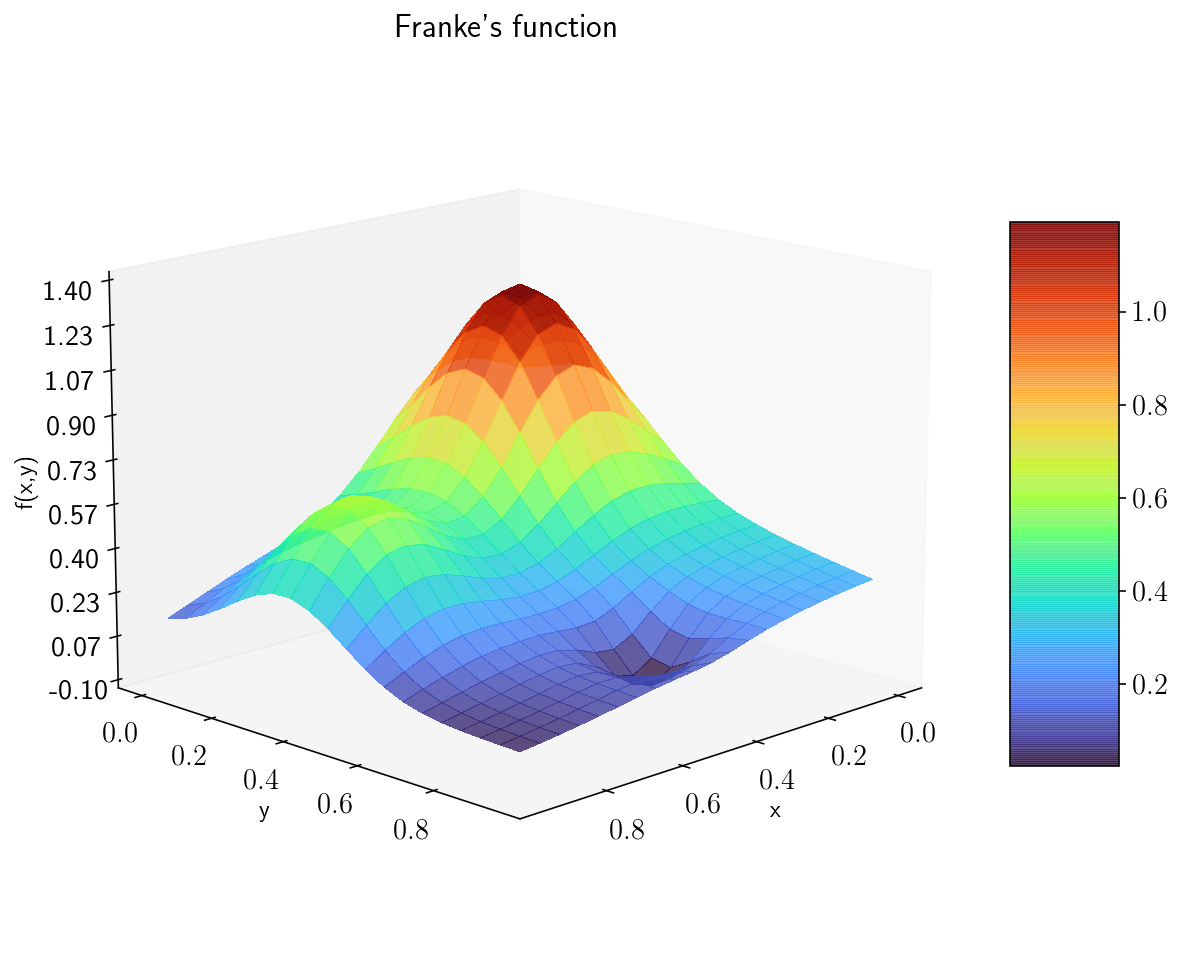

In [2]:
plotFranke(save=True)

# Ordinary Least Squares (OLS) Regression

## Part a)

### Create Data and Perform Ordinary Least Squares (OLS) Linear Regression

Here, we perform an ordinary least squares regression analysis using polynomials in $x$ and $y$ up to the fifth order. We split the data into training and test sets, and also scale the data. 

In [2]:
# Create data
np.random.seed(42)

n = 1000         # n x n number of data points
deg = 5          # degree
sigma2 = 0.001   # irreducible error

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma2, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# Generate design matrix
X = designMatrix(x, y, deg, with_intercept=False)
print(f"Design matrix shape: {X.shape}")

# Split data into train and test sets
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scale the data, i.e, subtract the mean and divide by std (based on the training set)
X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)

# Create linear regression object
ols_linreg = LinearRegression(fit_intercept=True)

# Train the model using the (scaled) training sets
ols_linreg.fit(X_train_scaled, z_train_scaled)

# Intercept and coefficients
beta0 = ols_linreg.intercept_
beta = ols_linreg.coef_
print(f"Intercept: {beta0}")
print("Coefficients: \n", beta)
print(f"Coefficients shape: {beta.shape}")

# MSE
mse_train = ols_linreg.mse(X_train_scaled, z_train_scaled)
mse_test = ols_linreg.mse(X_test_scaled, z_test_scaled)
print(f"Train MSE: {mse_train}")
print(f"Test MSE: {mse_test}")

# R2
r2_train = ols_linreg.r2(X_train_scaled, z_train_scaled)
r2_test = ols_linreg.r2(X_test_scaled, z_test_scaled)
print(f"Train R2: {r2_train}")
print(f"Test R2: {r2_test}")

Design matrix shape: (1000000, 20)
Intercept: -1.008838889440907
Coefficients: 
 [  2.3436139    1.13228893 -10.53940683  -3.45430516  -2.72430431
  14.12300541   9.08067947   4.19935828  -2.04767491  -6.53532505
  -9.87539403  -1.35424296  -5.41263025   7.59308977   0.39812408
   3.25022646   1.58302975  -0.77397686   2.77903013  -4.07868581]
Coefficients shape: (20,)
Train MSE: 0.002010131737724426
Test MSE: 0.002013920305208961
Train R2: 0.9756425585480896
Test R2: 0.9756147033588208


### MSE and R2 as a function of model complexity

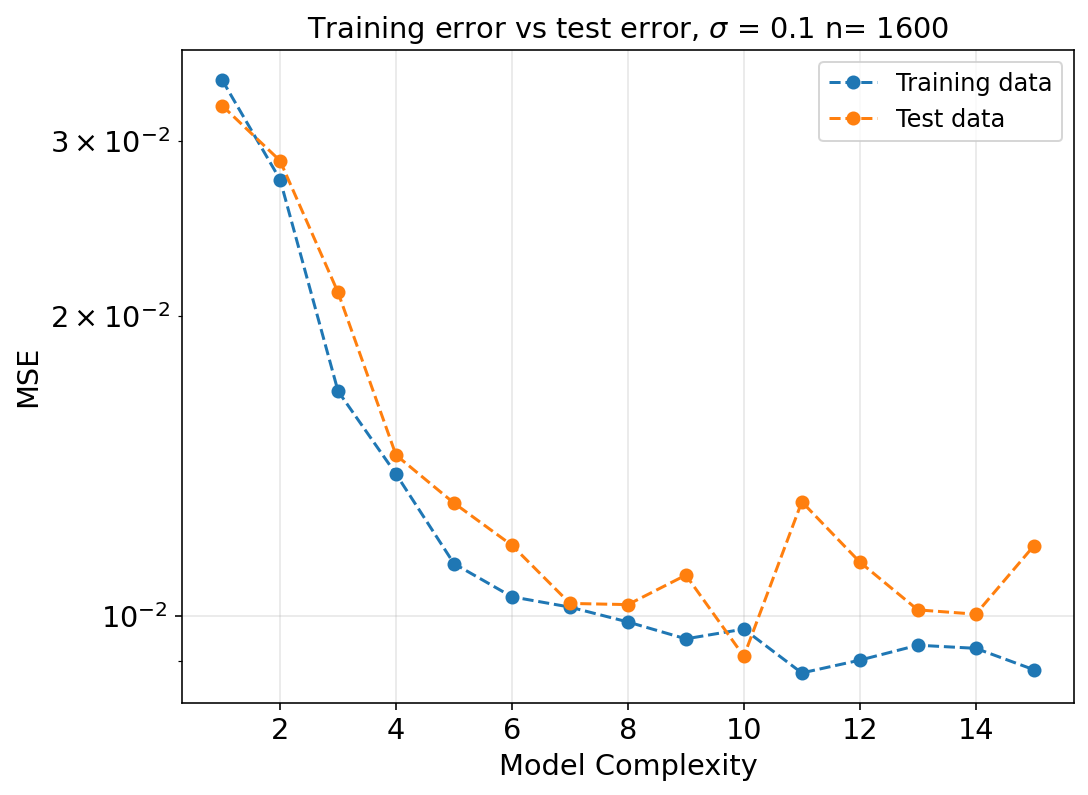

In [68]:
# Create data
np.random.seed(40)

n = 40         # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

maxdeg = 15
degrees = np.arange(1, maxdeg+1, dtype=int)

mse = pd.DataFrame(columns=["train", "test"], index=degrees-1)
r2 = pd.DataFrame(columns=["train", "test"], index=degrees-1)

for i, deg in enumerate(tqdm(degrees)):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)

    # Split data into train and test sets
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
    X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
    z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)

    # Create linear regression object
    ols_linreg = LinearRegression(fit_intercept=True)

    # Train the model using the (scaled) training sets
    ols_linreg.fit(X_train_scaled, z_train_scaled)
    z_fit = ols_linreg.predict(X_train_scaled)

    # Make predictions using the test set
    z_pred = ols_linreg.predict(X_test_scaled)

    # Statistical metrics
    mse["train"][i] = ols_linreg.mse(X_train_scaled, z_train_scaled)
    mse["test"][i] = ols_linreg.mse(X_test_scaled, z_test_scaled)    
    r2["train"][i] = ols_linreg.r2(X_train_scaled, z_train_scaled)
    r2["test"][i] = ols_linreg.r2(X_test_scaled, z_test_scaled)


fig = plt.figure(figsize=(8,6))
plt.plot(degrees, mse["train"], "o--", label="Training data")
plt.plot(degrees, mse["test"], "o--", label="Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.grid(alpha=0.3)
plt.legend()
plt.yscale('log')
plt.title(r'Training error vs test error, $\sigma$ = %g n= %g' % (sigma, len(x)))
plt.show()
fig.savefig(fig_path("MSE_forced_overfit.png"), dpi=300, transparent=True)

# Bootstrap within Monte-Carlo (MC)-like simulation

## Part b) 

The bootstrap method is a widely used resampling technique for identically distributed random variables.   

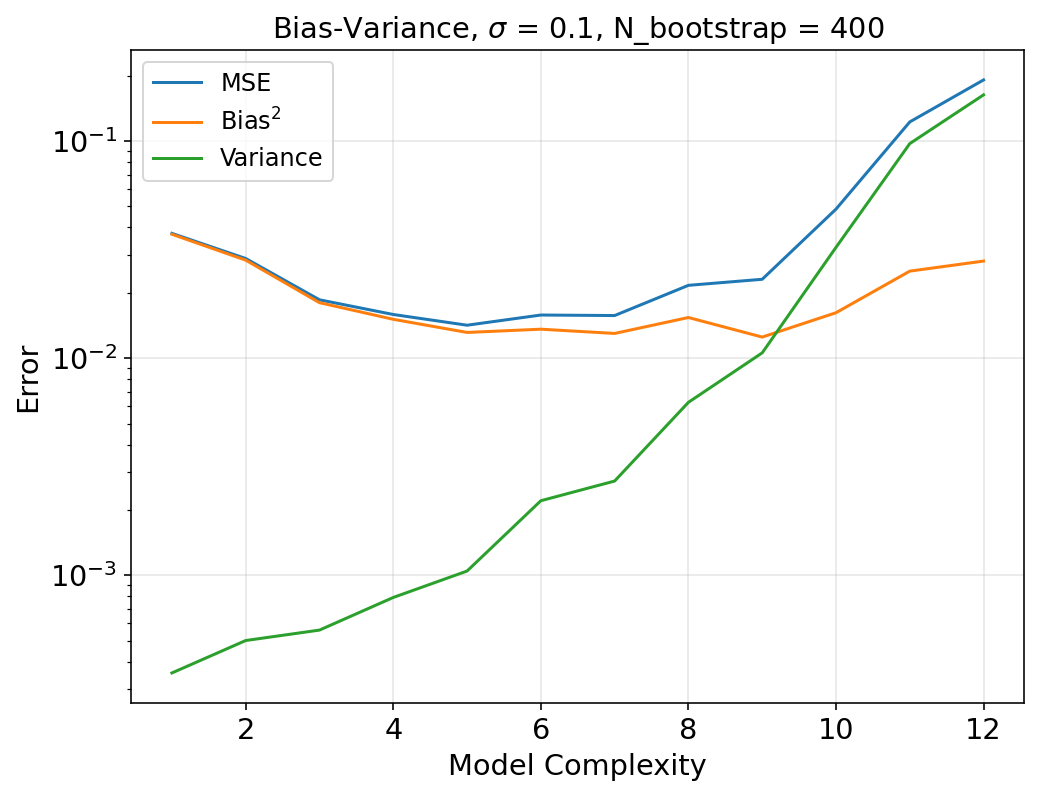

In [7]:
# Create data
np.random.seed(42)

n = 20         # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# setup for bootstrap
maxdeg = 12
degrees = np.arange(1, maxdeg+1, dtype=int)
n_bootstraps = 400
cycles = 20

bias2 = np.zeros(maxdeg)
variance = np.zeros(maxdeg)

for i, deg in enumerate(tqdm(degrees)):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)
    
    bias2_boot = np.zeros(cycles)
    variance_boot = np.zeros(cycles)
    
    for j in range(cycles):
        seed_value = np.random.randint(4000)
        np.random.seed(seed_value)
        
        # Split data into train and test sets
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

        # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
        X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
        z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)
        
        z_pred = np.empty((z_test.shape[0], n_bootstraps))
        
        for trial_idx in range(n_bootstraps):
            X_, z_ = resample(X_train_scaled, z_train_scaled)
            ols_linreg = LinearRegression(fit_intercept=True)
            ols_linreg.fit(X_, z_)
            z_pred[:, trial_idx] = ols_linreg.predict(X_test_scaled)
            
        bias2_boot[j] = np.mean((z_test_scaled - np.mean(z_pred, axis=1))**2) # bias^2
        variance_boot[j] = np.mean(np.var(z_pred, axis=1))

    bias2[i] = np.mean(bias2_boot)
    variance[i] = np.mean(variance_boot)
    
MSE = bias2 + variance
fig = plt.figure(figsize=(8, 6))
plt.grid(alpha=0.3)
plt.plot(degrees, MSE, label='MSE')
plt.plot(degrees, bias2, label=r'Bias$^2$')
plt.plot(degrees, variance, label='Variance')
plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.title(r'Bias-Variance, $\sigma$ = %g, N_bootstrap = %g' % (sigma, n_bootstraps))
plt.legend()
plt.yscale('log')
plt.show()
fig.savefig(fig_path("bias_variance_ols.png"), dpi=300, transparent=True)

## Confidence Interval

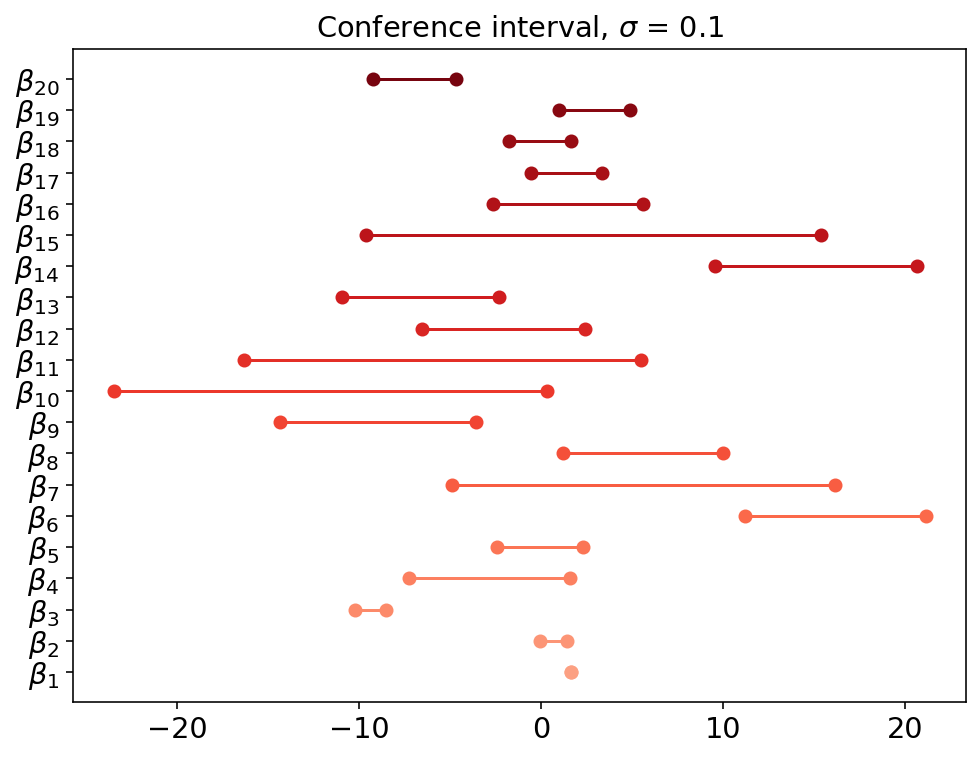

In [76]:
# Create data
np.random.seed(42)

n = 10     # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)
deg = 5

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))

# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# Generate design matrix
X = designMatrix(x, y, deg, with_intercept=False)

# Split data into train and test sets
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scale the data, i.e, subtract the mean and divide by std (based on the training set)
X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)

# Create linear regression object
ols_linreg = LinearRegression(fit_intercept=True)

# Train the model using the (scaled) training sets
ols_linreg.fit(X_train_scaled, z_train_scaled)

# Get 95% CI
Coef_interval = ols_linreg.coef_CI(critical_value=1.96)

# Plot the CI
plot_CI(Coef_interval, sigma, save=True)

# Cross Validation OLS

## Part c)

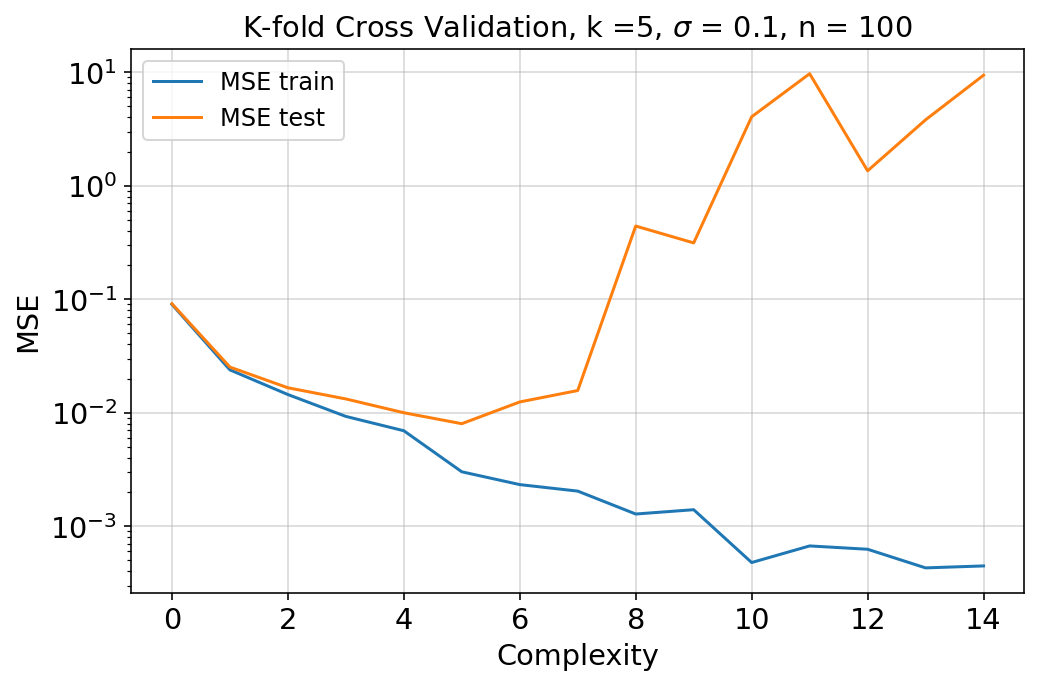

In [63]:
np.random.seed(40)

n = 10        # number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

k = 5
maxdeg = 15
degrees = np.arange(maxdeg)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))

# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)
n = len(x)
# Observed data
z = frankeFunction(x, y) + noise

scores_KFold_train = np.zeros(maxdeg)
scores_KFold_test = np.zeros(maxdeg)
      

MSE_test = np.zeros(len(degrees))
MSE_train = np.zeros(len(degrees))
k = 5
for degree in degrees:
    MSE_test[degree], MSE_train[degree] = Kfold(k, degree, n) #Kfold with small f is our own
    

fig = plt.figure(figsize=(8, 5))
plt.grid(alpha=0.5)
plt.plot(degrees, MSE_train, label='MSE train')
plt.plot(degrees,MSE_test, label='MSE test')
plt.legend()
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.title(r'K-fold Cross Validation, k =5, $\sigma$ = %g, n = %g' % (sigma, len(x)))
plt.yticks([10**n for n in range(-4,2)])
plt.yscale('log')
plt.show()
fig.savefig(fig_path("Cross_validation_OLS_highn"), dpi=300, transparent=True)

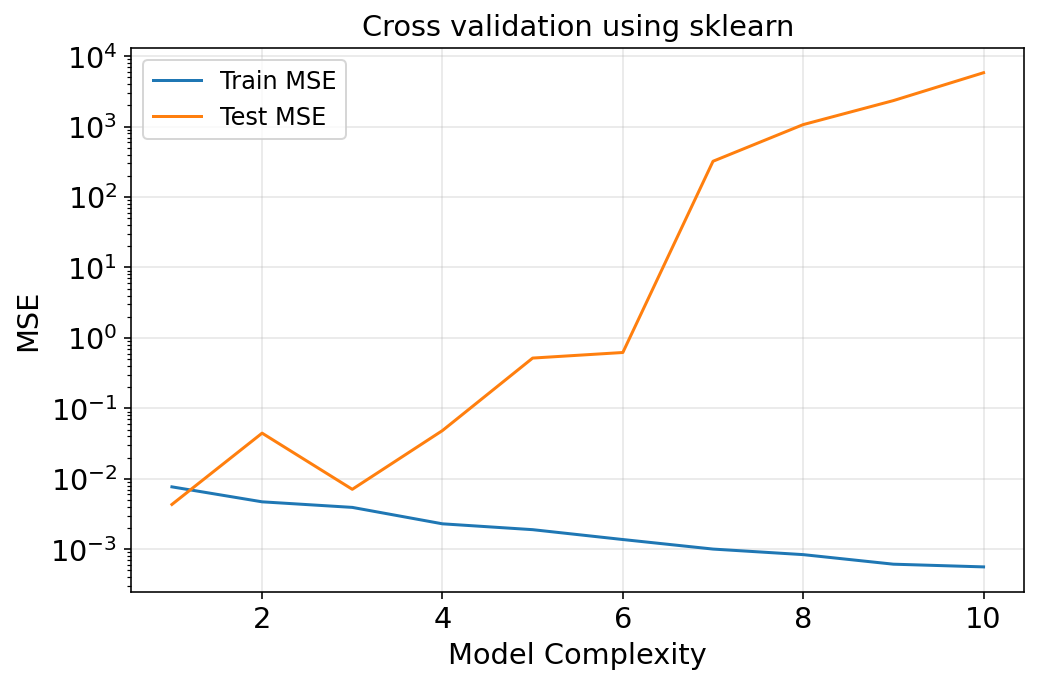

In [77]:
### Create data
np.random.seed(40)

n = 10          # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# setup for Cross-validation
maxdeg = 10
degrees = np.arange(1, maxdeg+1, dtype=int)

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)

# Perform the cross-validation to estimate MSE
scores_KFold_train = np.zeros((maxdeg, k))
scores_KFold_test = np.zeros((maxdeg, k))

for i, deg in enumerate(degrees):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]
        
        # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
        X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
        z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)
        
        ols_linreg = LinearRegression(fit_intercept=True)
        ols_linreg.fit(X_train_scaled, z_train_scaled)
        scores_KFold_train[i, j] = ols_linreg.mse(X_train_scaled, z_train_scaled)
        scores_KFold_test[i, j] = ols_linreg.mse(X_test_scaled, z_test_scaled)
        
    j += 1
    
estimated_mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
estimated_mse_KFold_test = np.mean(scores_KFold_test, axis = 1)

fig = plt.figure(figsize=(8, 5))
plt.grid(alpha=0.3)
plt.plot(degrees, estimated_mse_KFold_train, label='Train MSE')
plt.plot(degrees, estimated_mse_KFold_test, label='Test MSE')
plt.legend()
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.yscale('log')
plt.title('Cross validation using sklearn')
plt.show()
fig.savefig(fig_path("Cross_validation_OLS"), dpi=300, transparent=True)

# Ridge Regression

## Part d)

### Bootstrap

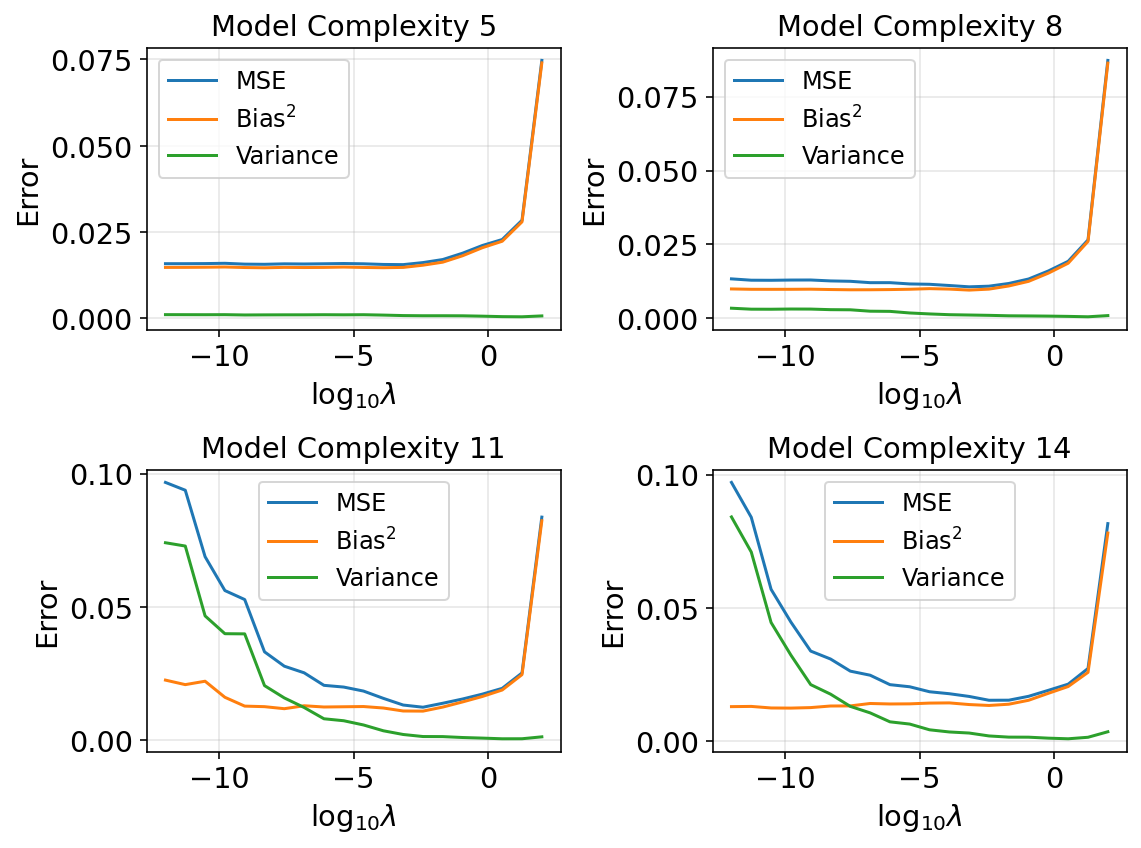

In [78]:
# Create data
np.random.seed(41)

n = 20          # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))

# create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# observed data
z = frankeFunction(x, y) + noise

degrees = [5, 8, 11, 14]

# setup for bootstrap
N = 20
lmbdas = np.logspace(-12, 2, N)
n_bootstraps = 500

bias2 = np.zeros(N)
variance = np.zeros(N)


fig = plt.figure(figsize=(8, 6))

for i, deg in enumerate(tqdm(degrees)):
    
    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)

    # Split data into train and test sets
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # scale the data
    X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
    z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)
    
    for j, lmbda in enumerate(lmbdas):

        z_pred = np.empty((z_test.shape[0], n_bootstraps))

        for trial_idx in range(n_bootstraps):
            X_, z_ = resample(X_train_scaled, z_train_scaled)
            ridge_reg = RidgeRegression(lmbda=lmbda, fit_intercept=True)
            ridge_reg.fit(X_, z_)
            z_pred[:, trial_idx] = ridge_reg.predict(X_test_scaled)

        bias2[j] = np.mean((z_test_scaled - np.mean(z_pred, axis=1))**2)  # bias^2
        variance[j] = np.mean(np.var(z_pred, axis=1))
    
    MSE = bias2 + variance
    ax = fig.add_subplot(2, 2, i+1)
    ax.grid(alpha=0.3)
    ax.plot(np.log10(lmbdas), MSE, label='MSE')
    ax.plot(np.log10(lmbdas), bias2, label=r'Bias$^2$')
    ax.plot(np.log10(lmbdas), variance, label='Variance')
    ax.set_xlabel(r"$\log_{10} \lambda$")
    ax.set_ylabel("Error")
    ax.set_title(f"Model Complexity {deg}")
    ax.legend()
    
plt.tight_layout(True)
plt.show()
fig.savefig(fig_path("bias_variance_ridge.png"), dpi=300, transparent=True)

### Cross Validation

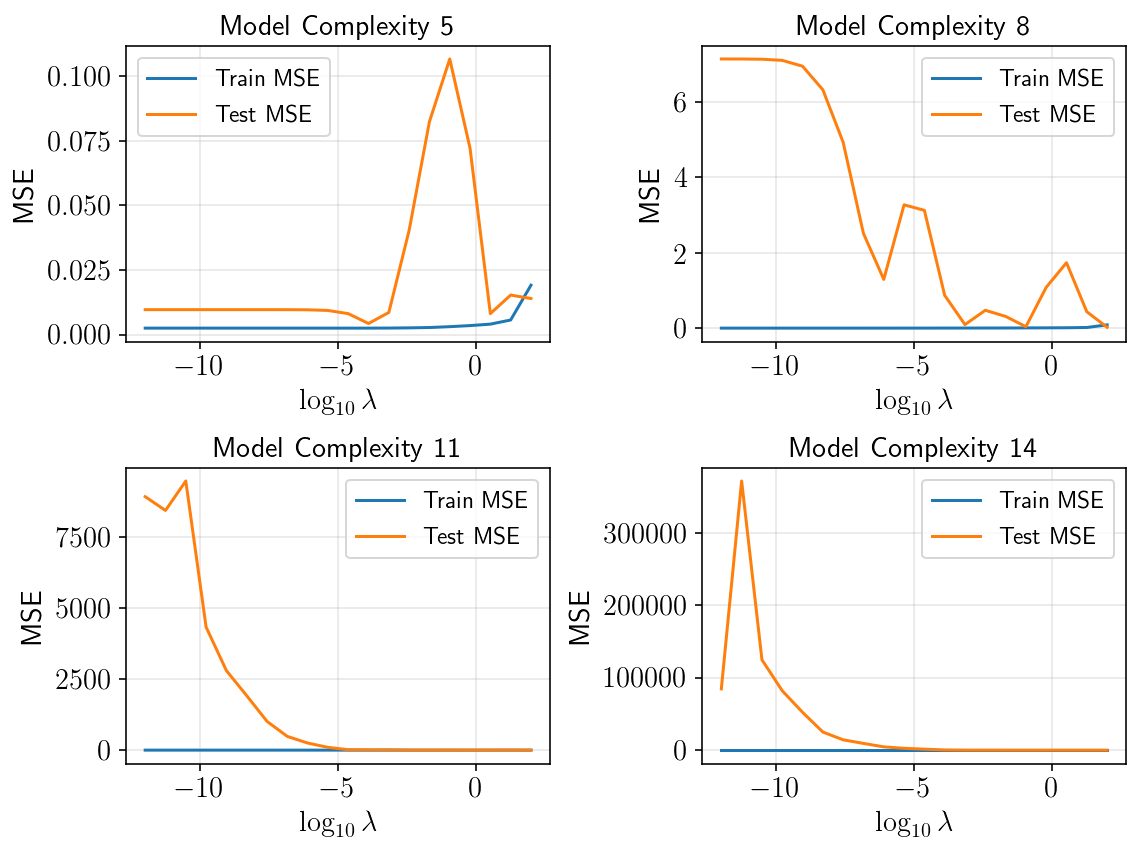

In [44]:
# Create data
np.random.seed(42)

n = 20          # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

degrees = [5, 8, 11, 14]

# setup for cross-validation
N = 20
lmbdas = np.logspace(-12, 2, N)

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)

fig = plt.figure(figsize=(8, 6))

for i, deg in enumerate(tqdm(degrees)):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)
    
    # Perform the cross-validation to estimate MSE
    scores_KFold_train = np.zeros((N, k))
    scores_KFold_test = np.zeros((N, k))

    for j, lmbda in enumerate(lmbdas):
    
        k = 0
        for train_inds, test_inds in kfold.split(x):
            X_train = X[train_inds]
            z_train = z[train_inds]

            X_test = X[test_inds]
            z_test = z[test_inds]

            # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
            X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
            z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)

            ridge_reg = RidgeRegression(lmbda=lmbda, fit_intercept=True)
            ridge_reg.fit(X_train_scaled, z_train_scaled)
            scores_KFold_train[j, k] = ridge_reg.mse(X_train_scaled, z_train_scaled)
            scores_KFold_test[j, k] = ridge_reg.mse(X_test_scaled, z_test_scaled)
        k += 1
    
    estimated_mse_KFold_train = np.mean(scores_KFold_train, axis=1)
    estimated_mse_KFold_test = np.mean(scores_KFold_test, axis=1)
    
    ax = fig.add_subplot(2, 2, i+1)
    ax.grid(alpha=0.3)
    ax.plot(np.log10(lmbdas), estimated_mse_KFold_train, label='Train MSE')
    ax.plot(np.log10(lmbdas), estimated_mse_KFold_test, label='Test MSE')
    ax.set_xlabel(r"$\log_{10} \lambda$")
    ax.set_ylabel("MSE")
    ax.set_title(f"Model Complexity {deg}")
    ax.legend()

plt.tight_layout(True)
plt.show()
fig.savefig(fig_path("Cross_validation_Ridge"), dpi=300, transparent=True)

# Lasso Regression

## Part e)

### Bootstrap

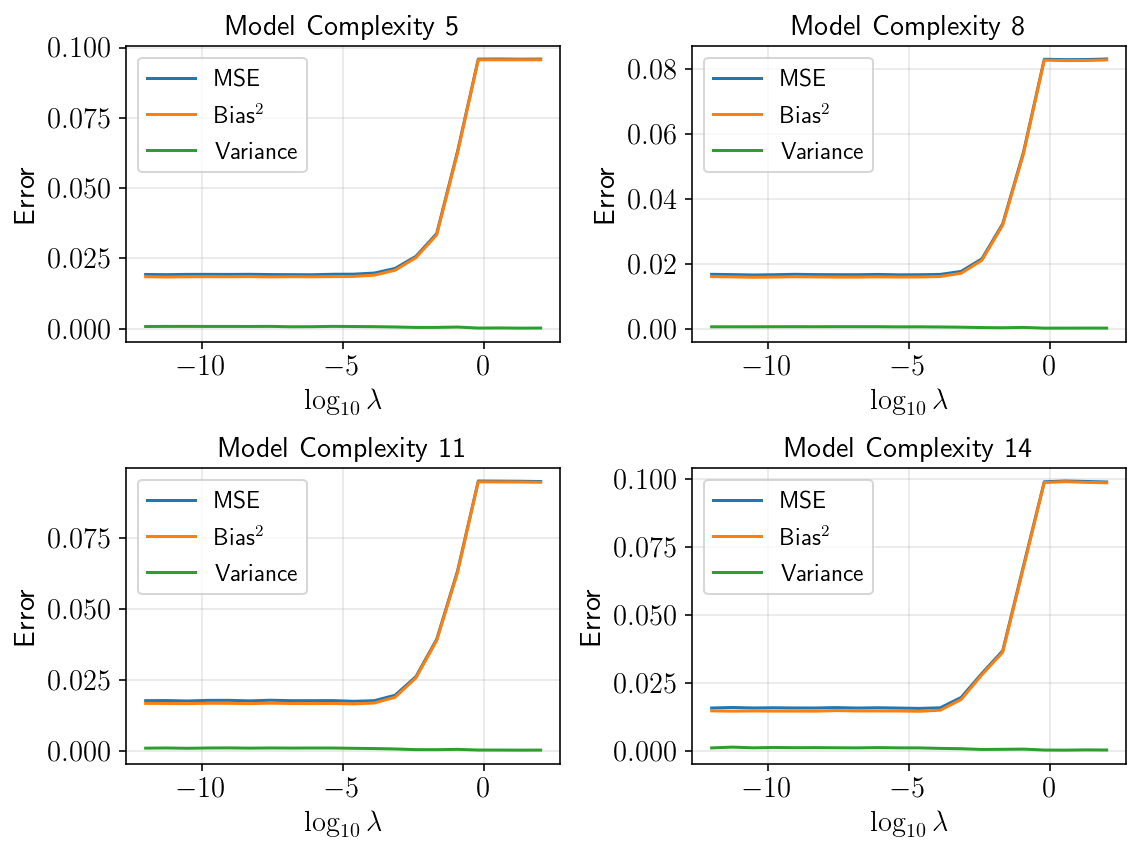

In [48]:
# Create data
np.random.seed(41)

n = 20          # n x n number of data points
sigma2 = 0.01    # irreducible error
sigma = np.sqrt(sigma2)


x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))

# create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# observed data
z = frankeFunction(x, y) + noise

degrees = [5, 8, 11, 14]

# setup for bootstrap
N = 20
lmbdas = np.logspace(-12, 2, N)
n_bootstraps = 300

bias2 = np.zeros(N)
variance = np.zeros(N)


fig = plt.figure(figsize=(8, 6))

for i, deg in enumerate(tqdm(degrees)):
    
    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)

    # Split data into train and test sets
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # scale the data
    X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
    z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)
    
    for j, lmbda in enumerate(lmbdas):

        z_pred = np.empty((z_test.shape[0], n_bootstraps))

        for trial_idx in range(n_bootstraps):
            X_, z_ = resample(X_train_scaled, z_train_scaled)
            lasso_reg = Lasso(alpha=lmbda, fit_intercept=True)
            lasso_reg.fit(X_, z_)
            z_pred[:, trial_idx] = lasso_reg.predict(X_test_scaled)

        bias2[j] = np.mean((z_test_scaled - np.mean(z_pred, axis=1))**2)  # bias^2
        variance[j] = np.mean(np.var(z_pred, axis=1))
    
    MSE = bias2 + variance
    ax = fig.add_subplot(2, 2, i+1)
    ax.grid(alpha=0.3)
    ax.plot(np.log10(lmbdas), MSE, label='MSE')
    ax.plot(np.log10(lmbdas), bias2, label=r'Bias$^2$')
    ax.plot(np.log10(lmbdas), variance, label='Variance')
    ax.set_xlabel(r"$\log_{10} \lambda$")
    ax.set_ylabel("Error")
    ax.set_title(f"Model Complexity {deg}")
    ax.legend()
    
plt.tight_layout(True)
plt.show()
fig.savefig(fig_path("bias_variance_lasso.png"), dpi=300, transparent=True)


lasso penalizer mye, gir en lite fleksibel modell for lasso regresjon. får mye bias. 

### Cross-Validation Lasso

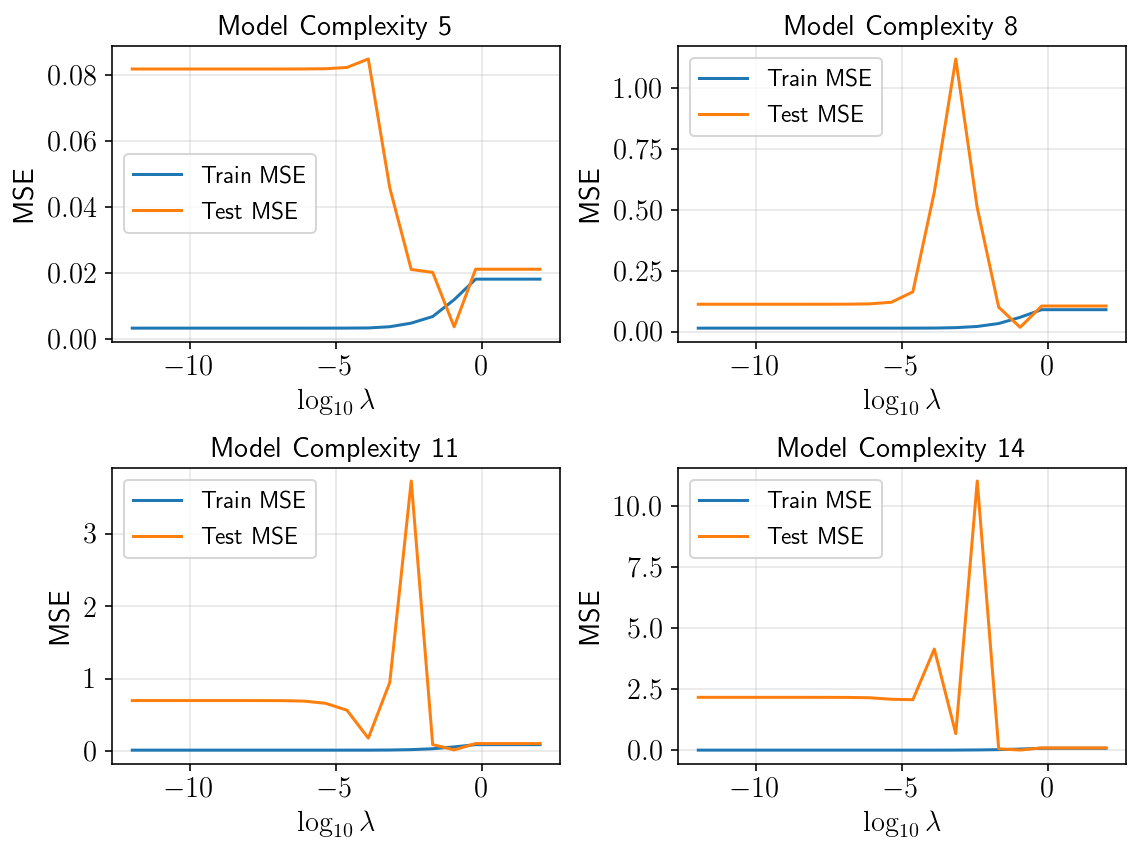

In [54]:
# Create data
np.random.seed(42)

n = 20          # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

degrees = [5, 8, 11, 14]

# setup for cross-validation
N = 20
lmbdas = np.logspace(-12, 2, N)

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)

fig = plt.figure(figsize=(8, 6))

for i, deg in enumerate(tqdm(degrees)):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)
    
    # Perform the cross-validation to estimate MSE
    scores_KFold_train = np.zeros((N, k))
    scores_KFold_test = np.zeros((N, k))

    for j, lmbda in enumerate(lmbdas):
    
        k = 0
        for train_inds, test_inds in kfold.split(x):
            X_train = X[train_inds]
            z_train = z[train_inds]

            X_test = X[test_inds]
            z_test = z[test_inds]

            # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
            X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
            z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)

            lasso_reg = Lasso(alpha=lmbda, fit_intercept=True)
            lasso_reg.fit(X_train_scaled, z_train_scaled)
            
            z_fit = lasso_reg.predict(X_train_scaled)

            # Make predictions using the test set
            z_pred = lasso_reg.predict(X_test_scaled)
            
            scores_KFold_train[j, k] = mean_squared_error(z_train_scaled, z_fit)
            scores_KFold_test[j, k] = mean_squared_error(z_test_scaled, z_pred)
        k += 1
    
    estimated_mse_KFold_train = np.mean(scores_KFold_train, axis=1)
    estimated_mse_KFold_test = np.mean(scores_KFold_test, axis=1)
    
    ax = fig.add_subplot(2, 2, i+1)
    ax.grid(alpha=0.3)
    ax.plot(np.log10(lmbdas), estimated_mse_KFold_train, label='Train MSE')
    ax.plot(np.log10(lmbdas), estimated_mse_KFold_test, label='Test MSE')
    ax.set_xlabel(r"$\log_{10} \lambda$")
    ax.set_ylabel("MSE")
    ax.set_title(f"Model Complexity {deg}")
    ax.legend()

plt.tight_layout(True)
plt.show()
fig.savefig(fig_path("Cross_validation_Lasso"), dpi=300, transparent=True)

# Digital Terrain Data

## Part f)

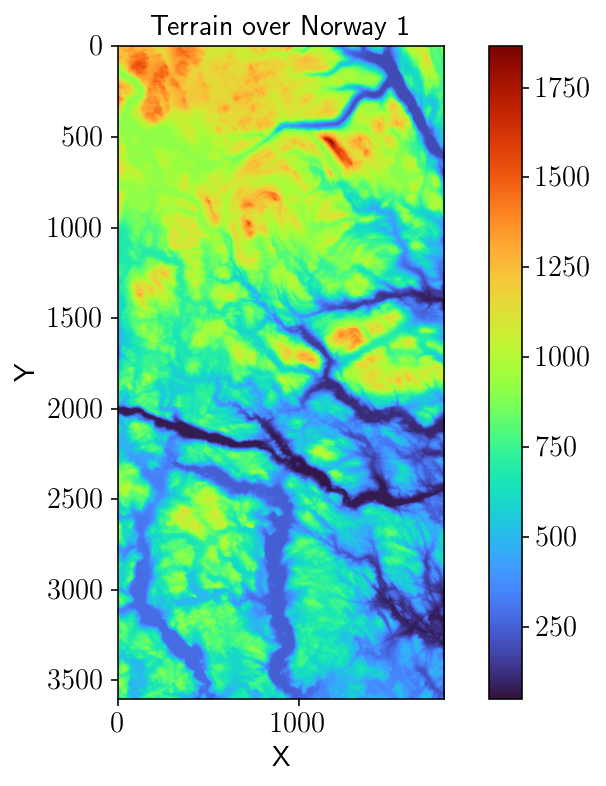

In [80]:
# Load the terrain
terrain = imread('SRTM_data_Norway_1.tif')

# Show the terrain
plt.figure(figsize=(8,6))
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap="turbo")
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.show()
fig.savefig(fig_path("scaled_terrain.png"), dpi=300)

# OLS, Ridge and Lasso regression with cross-validation on terrain data

## Part g)


### CV - OLS 

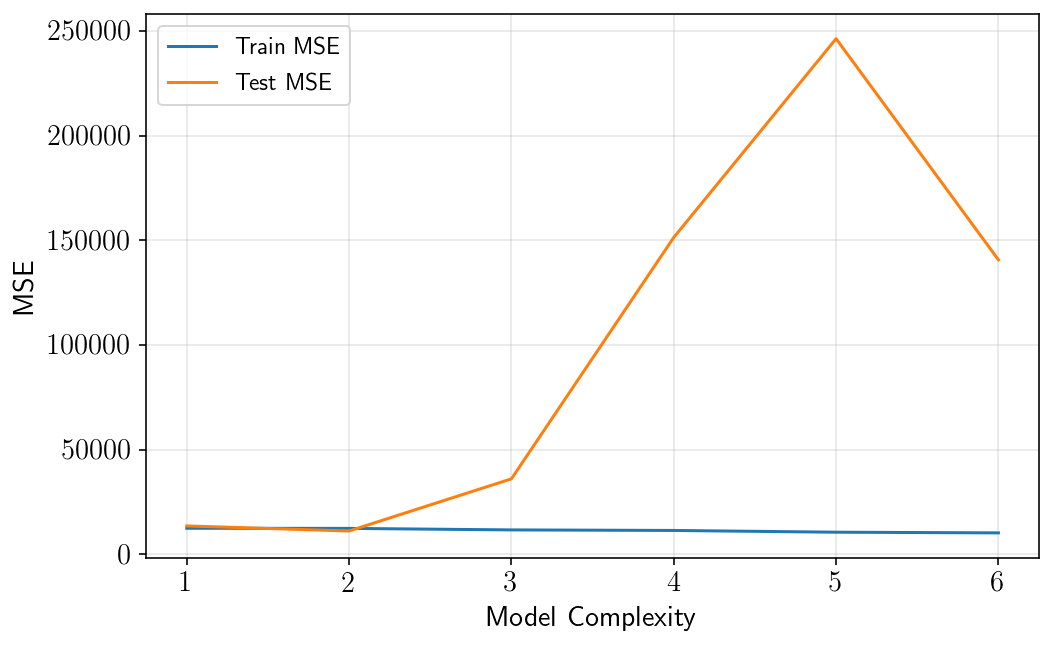

In [70]:
# Load the terrain
terrain = imread('SRTM_data_Norway_1.tif')

slice_idx = 10
terrain = terrain[::slice_idx, ::slice_idx]

nx = np.shape(terrain)[0]
ny = np.shape(terrain)[1]

# Creates mesh of image pixels
x = np.linspace(0, 1, np.shape(terrain)[0])
y = np.linspace(0, 1, np.shape(terrain)[1])
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

z = terrain.ravel()

# setup for Cross-validation
maxdeg = 6
degrees = np.arange(1, maxdeg+1, dtype=int)

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)

# Perform the cross-validation to estimate MSE
scores_KFold_train = np.zeros((maxdeg, k))
scores_KFold_test = np.zeros((maxdeg, k))

for i, deg in enumerate(degrees):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]
        
        # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
        X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
        z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)
        
        ols_linreg = LinearRegression(fit_intercept=True)
        ols_linreg.fit(X_train_scaled, z_train_scaled)
        scores_KFold_train[i, j] = ols_linreg.mse(X_train_scaled, z_train_scaled)
        scores_KFold_test[i, j] = ols_linreg.mse(X_test_scaled, z_test_scaled)
        
    j += 1
    
estimated_mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
estimated_mse_KFold_test = np.mean(scores_KFold_test, axis = 1)

fig = plt.figure(figsize=(8, 5))
plt.grid(alpha=0.3)
plt.plot(degrees, estimated_mse_KFold_train, label='Train MSE')
plt.plot(degrees, estimated_mse_KFold_test, label='Test MSE')
plt.legend()
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.show()
fig.savefig(fig_path("Cross_validation_OLS_terrain"), dpi=300, transparent=True)


### CV - RIDGE

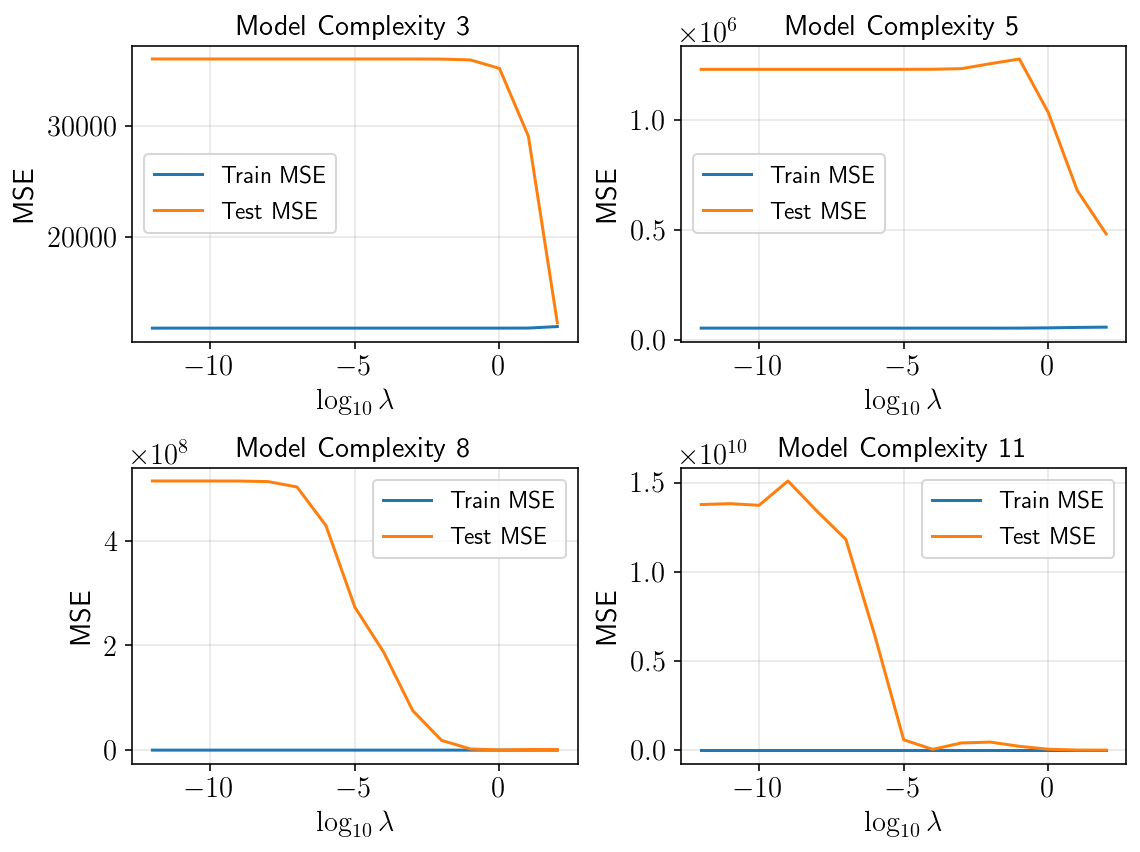

In [73]:
# Load the terrain
terrain = imread('SRTM_data_Norway_1.tif')

slice_idx = 10
terrain = terrain[::slice_idx, ::slice_idx]

nx = np.shape(terrain)[0]
ny = np.shape(terrain)[1]

# Creates mesh of image pixels
x = np.linspace(0, 1, np.shape(terrain)[0])
y = np.linspace(0, 1, np.shape(terrain)[1])
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

z = terrain.ravel()

degrees = [3, 5, 8, 11]

# setup for cross-validation
N = 15
lmbdas = np.logspace(-12, 2, N)

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)

fig = plt.figure(figsize=(8, 6))

for i, deg in enumerate(tqdm(degrees)):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)
    
    # Perform the cross-validation to estimate MSE
    scores_KFold_train = np.zeros((N, k))
    scores_KFold_test = np.zeros((N, k))

    for j, lmbda in enumerate(lmbdas):
    
        k = 0
        for train_inds, test_inds in kfold.split(x):
            X_train = X[train_inds]
            z_train = z[train_inds]

            X_test = X[test_inds]
            z_test = z[test_inds]

            # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
            X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
            z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)

            ridge_reg = RidgeRegression(lmbda=lmbda, fit_intercept=True)
            ridge_reg.fit(X_train_scaled, z_train_scaled)
            scores_KFold_train[j, k] = ridge_reg.mse(X_train_scaled, z_train_scaled)
            scores_KFold_test[j, k] = ridge_reg.mse(X_test_scaled, z_test_scaled)
        k += 1
    
    estimated_mse_KFold_train = np.mean(scores_KFold_train, axis=1)
    estimated_mse_KFold_test = np.mean(scores_KFold_test, axis=1)
    
    ax = fig.add_subplot(2, 2, i+1)
    ax.grid(alpha=0.3)
    ax.plot(np.log10(lmbdas), estimated_mse_KFold_train, label='Train MSE')
    ax.plot(np.log10(lmbdas), estimated_mse_KFold_test, label='Test MSE')
    ax.set_xlabel(r"$\log_{10} \lambda$")
    ax.set_ylabel("MSE")
    ax.set_title(f"Model Complexity {deg}")
    ax.legend()

plt.tight_layout(True)
plt.show()
fig.savefig(fig_path("Cross_validation_Ridge_terrain"), dpi=300, transparent=True)

### CV - LASSO

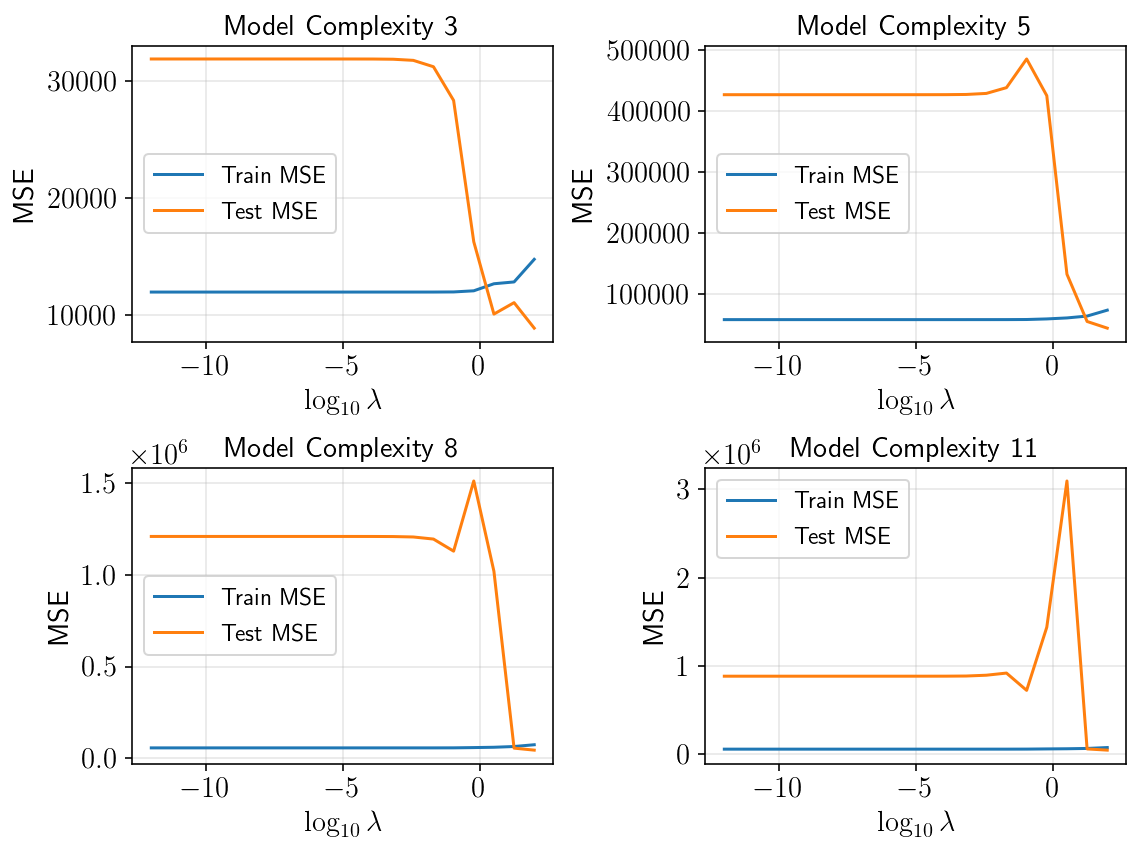

In [76]:
# Load the terrain
terrain = imread('SRTM_data_Norway_1.tif')

slice_idx = 50
terrain = terrain[::slice_idx, ::slice_idx]

nx = np.shape(terrain)[0]
ny = np.shape(terrain)[1]

# Creates mesh of image pixels
x = np.linspace(0, 1, np.shape(terrain)[0])
y = np.linspace(0, 1, np.shape(terrain)[1])
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

z = terrain.ravel()

degrees = [3, 5, 8, 11]

# setup for cross-validation
N = 20
lmbdas = np.logspace(-12, 2, N)

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)

fig = plt.figure(figsize=(8, 6))

for i, deg in enumerate(tqdm(degrees)):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)
    
    # Perform the cross-validation to estimate MSE
    scores_KFold_train = np.zeros((N, k))
    scores_KFold_test = np.zeros((N, k))

    for j, lmbda in enumerate(lmbdas):
    
        k = 0
        for train_inds, test_inds in kfold.split(x):
            X_train = X[train_inds]
            z_train = z[train_inds]

            X_test = X[test_inds]
            z_test = z[test_inds]

            # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
            X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
            z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)

            lasso_reg = Lasso(alpha=lmbda, fit_intercept=True)
            lasso_reg.fit(X_train_scaled, z_train_scaled)
            
            z_fit = lasso_reg.predict(X_train_scaled)

            # Make predictions using the test set
            z_pred = lasso_reg.predict(X_test_scaled)
            
            scores_KFold_train[j, k] = mean_squared_error(z_train_scaled, z_fit)
            scores_KFold_test[j, k] = mean_squared_error(z_test_scaled, z_pred)
        k += 1
    
    estimated_mse_KFold_train = np.mean(scores_KFold_train, axis=1)
    estimated_mse_KFold_test = np.mean(scores_KFold_test, axis=1)
    
    ax = fig.add_subplot(2, 2, i+1)
    ax.grid(alpha=0.3)
    ax.plot(np.log10(lmbdas), estimated_mse_KFold_train, label='Train MSE')
    ax.plot(np.log10(lmbdas), estimated_mse_KFold_test, label='Test MSE')
    ax.set_xlabel(r"$\log_{10} \lambda$")
    ax.set_ylabel("MSE")
    ax.set_title(f"Model Complexity {deg}")
    ax.legend()

plt.tight_layout(True)
plt.show()
fig.savefig(fig_path("Cross_validation_Lasso_terrain"), dpi=300, transparent=True)